**Making another model for classification with some changes**

In [27]:
from sklearn.datasets import make_circles
n_samples = 1000
X, y = make_circles(n_samples, noise=0.05, random_state=42)
print(X)
# print(y)

[[ 0.74220688  0.24668576]
 [-0.7340323   0.16869164]
 [-0.82985872  0.22195899]
 ...
 [-0.12823057 -0.82613318]
 [ 0.66090453 -0.79319015]
 [ 0.27841491  0.96735953]]


In [28]:
import pandas as pd
circle_df = pd.DataFrame({"X1": X[:, 0], "X2": X[:, 1], 'label': y})
circle_df.head(10)

,X1,X2,label
0,0.742207,0.246686,1
1,-0.734032,0.168692,1
2,-0.829859,0.221959,1
3,-0.429136,0.672230,1
4,0.445602,-0.894936,0
5,-0.469885,0.708037,1
6,-0.016045,0.805623,1
7,0.759623,0.159526,1
8,-0.175692,-0.799837,1
9,-0.110616,1.042207,0


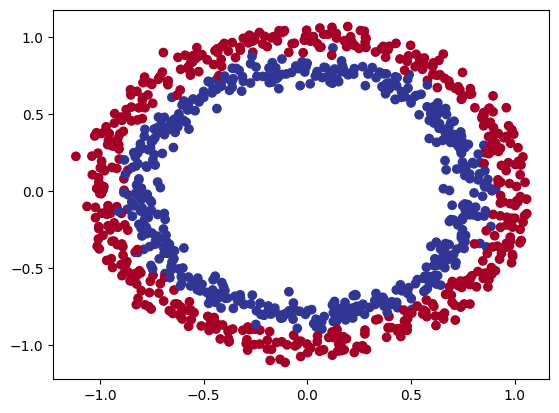

In [29]:
import matplotlib.pyplot as plt
plt.scatter(x=X[:, 0], y=X[:, 1], c=y, cmap=plt.cm.RdYlBu)
plt.show()

In [30]:
# for training, testing, making X,y into tensor
import torch
X = torch.from_numpy(X).type(torch.float)
y = torch.from_numpy(y).type(torch.float)

In [31]:
# splitting data into training, testing
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42,
                                                    test_size=0.2  # 80% training, 20% testing
                                                    )

print(len(X_train))
print(len(X_test))
print(len(y_train))
print(len(y_test))

800
200
800
200


In [32]:
# setting up device
device = "cuda" if torch.cuda.is_available() else "cpu"
print(device)

cpu


In [33]:
from torch import nn
class CircleModelV1(nn.Module):
    def __init__(self):
        super().__init__()
        self.layer_1=nn.Linear(in_features=2, out_features=10)
        self.layer_2=nn.Linear(in_features=10, out_features=10)
        self.layer_3=nn.Linear(in_features=10, out_features=1)

    def forward(self, x):
        return self.layer_3(self.layer_2(self.layer_1(x)))
    
model_1=CircleModelV1().to(device)
model_1

CircleModelV1(
  (layer_1): Linear(in_features=2, out_features=10, bias=True)
  (layer_2): Linear(in_features=10, out_features=10, bias=True)
  (layer_3): Linear(in_features=10, out_features=1, bias=True)
)

In [34]:
# loss function/optimization
loss_fn=nn.BCEWithLogitsLoss()
optimizer=torch.optim.SGD(params=model_1.parameters(),lr=0.1)

In [35]:
# accuracy function
def accuracy_fn(y_true, y_pred):
    correct=torch.eq(y_true,y_pred).sum().item()
    acc=(correct/len(y_pred))*100
    return acc

**Training Testing**

In [36]:
torch.manual_seed(seed=42)
epochs = 1000 #Training for Longer

# putting data on target device
X_train = X_train.to(device)
X_test = X_test.to(device)
y_train = y_train.to(device)
y_test = y_test.to(device)


for epoch in range(epochs):

    # Training Loop
    model_1.train()  # setting up

    # forward pass
    y_logits = model_1(X_train).squeeze()
    y_pred = torch.round(torch.sigmoid(y_logits))

    # loss function,accuracy
    loss = loss_fn(y_logits,  # nn.BCEWithLogitsLoss(): works with raw logits
                   y_train)  # calculating loss between `predicted` and `actual` value
    acc = accuracy_fn(y_true=y_train, y_pred=y_pred)

    # zero grad optimizer
    optimizer.zero_grad()

    # backpropagation of loss
    loss.backward()

    # updation
    optimizer.step()

    # Testing Loop
    model_1.eval()
    with torch.inference_mode():

        # forward pass
        test_logits = model_1(X_test).squeeze()
        test_pred = torch.round(torch.sigmoid(test_logits))

        # loss/accuracy
        # calculating loss between `predicted` and `actual` value
        test_loss = loss_fn(test_logits, y_test)
        test_acc = accuracy_fn(y_true=y_test,
                               y_pred=test_pred)

    if epoch % 100 == 0:
        print(
            f"Epoch: {epoch} | Loss: {loss:.5f}, Accuracy: {acc:.2f}% | Test loss: {test_loss:.5f}, Test acc: {test_acc:.2f}%")

Epoch: 0 | Loss: 0.69393, Accuracy: 51.00% | Test loss: 0.69264, Test acc: 50.00%
Epoch: 100 | Loss: 0.69305, Accuracy: 50.50% | Test loss: 0.69379, Test acc: 48.00%
Epoch: 200 | Loss: 0.69299, Accuracy: 51.12% | Test loss: 0.69436, Test acc: 47.00%
Epoch: 300 | Loss: 0.69298, Accuracy: 51.00% | Test loss: 0.69456, Test acc: 46.00%
Epoch: 400 | Loss: 0.69298, Accuracy: 51.38% | Test loss: 0.69463, Test acc: 45.50%
Epoch: 500 | Loss: 0.69298, Accuracy: 51.62% | Test loss: 0.69465, Test acc: 45.50%
Epoch: 600 | Loss: 0.69298, Accuracy: 51.62% | Test loss: 0.69466, Test acc: 45.50%
Epoch: 700 | Loss: 0.69298, Accuracy: 51.62% | Test loss: 0.69466, Test acc: 45.50%
Epoch: 800 | Loss: 0.69298, Accuracy: 51.62% | Test loss: 0.69466, Test acc: 45.50%
Epoch: 900 | Loss: 0.69298, Accuracy: 51.62% | Test loss: 0.69466, Test acc: 45.50%


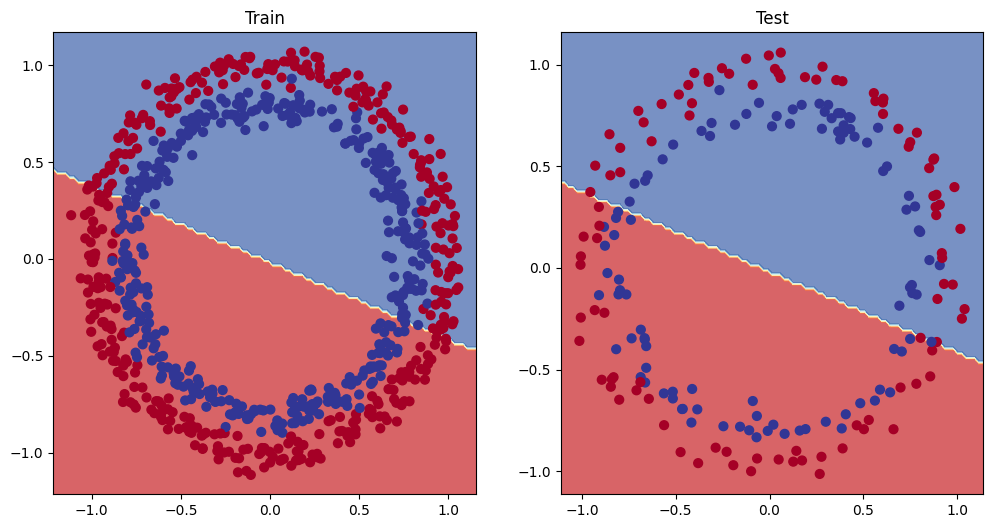

In [38]:
# plotting plot_decision_boundary
from helper_functions import plot_decision_boundary

plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
plt.title('Train')
plot_decision_boundary(model_1, X_train, y_train)
plt.subplot(1,2,2)
plt.title('Test')
plot_decision_boundary(model_1,X_test, y_test)

**By increasing `epoch`, model predict same nature**
for non-linearity, we can use another methods too